# Wasserstien GAN

In [1]:
import numpy as np
from keras.preprocessing import image
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import *
from keras.optimizers import Adam, RMSprop
import keras.backend as K
import keras
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

Using TensorFlow backend.


## Import and prep the MNIST data

In [2]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)


In [0]:
X_train = X_train.reshape(-1, 28, 28, 1).astype(np.float32)
X_test = X_test.reshape(-1, 28, 28, 1).astype(np.float32)

In [0]:
X_train /= 255.; X_test /= 255.

In [0]:
n = len(X_train)

## Utility functions

generate a length 100 vector of random noise to feed the generator

In [0]:
def noise(batch_size): return np.random.rand(batch_size, 100)

lock or release the weights of a model for training

In [0]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers: l.trainable = val

This is the main training loop. It contains two of the important improvements suggested by the wasserstien gan paper, namely to periodically train the discriminator more heavily and to clip the weights to a restricted set of values.

Training progresses in two steps, with the descriminator being trained on a batch containing half real and half generated images, then the discriminators weights are locked and the full model is trained, using wasserstien loss on the discriminators predictions to update the weights of the generator.

In [0]:
def train(D, G, m, epochs=2500, batch_size=128):
    gen_iterations = 0
    rl = []; fl = []; dl = []; gl= []
    for epoch in tqdm(range(epochs)):
        make_trainable(D, True)
        # First Wasserstien improvement:
        # Periodically train D more heavily
        if gen_iterations < 25 or gen_iterations % 500 == 0:
            disc_iterations = 100
        else:
            disc_iterations = 5
        
        # Train the discriminator
        for iteration in range(disc_iterations):
            # Second Wasserstien improvement:
            # Clip weights -0.01 to 0.01
            for l in D.layers:
                weights = l.get_weights()
                weights = [np.clip(w, -0.01, 0.01) for w in weights]
                l.set_weights(weights)
            
            # Create batch of data and update discriminator
            half_batch = batch_size//2
            x_real_d = X_train[np.random.randint(0, n, size=half_batch)]
            rl.append(D.train_on_batch(x_real_d, [-1]*half_batch))
            
            x_gen_d = G.predict(noise(half_batch))
            fl.append(D.train_on_batch(x_gen_d, [1]*half_batch))
            
            dl.append(np.mean([-rl[-1], fl[-1]]))
        
        make_trainable(D, False)
        
        # Train the generator
        gl.append(m.train_on_batch(noise(batch_size), [-1]*batch_size))
        gen_iterations += 1
        
    return rl,fl,dl,gl

## Generator Model

Simple model with a fully connected block, followed by two upsampling blocks, then a final convolution layer.

In [9]:
filters = 512
gen_input = Input(shape=(100,), name="generator_input")
xg = Dense(512 * 7 * 7, input_dim=100)(gen_input)
xg = LeakyReLU()(xg)
xg = BatchNormalization()(xg)
xg = Reshape((7, 7, 512))(xg)

# Upsample to 14x14
xg = UpSampling2D()(xg)
xg = Conv2D(64, (3,3), padding='same')(xg)
xg = BatchNormalization()(xg)
xg = LeakyReLU()(xg)

# Upsample to 28x28
xg = UpSampling2D()(xg)
xg = Conv2D(32, (3,3), padding='same')(xg)
xg = BatchNormalization()(xg)
xg = LeakyReLU()(xg)

xg = Conv2D(1, (1,1), padding='same', activation='sigmoid')(xg)
generator_model = Model(inputs=[gen_input], outputs=[xg], name='RyanGAN_G')

In [10]:
generator_model.summary()

Model: "RyanGAN_G"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 25088)             2533888   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 25088)             0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 25088)             100352    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 512)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 512)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        29

## Discriminator Model

In [0]:
min_s = 28
num_convolutions = int(np.floor(np.log(min_s // 4) / np.log(2)))
list_filters = [64 * min(8, (2 ** i)) for i in range(num_convolutions)]

disc_input = Input(shape=(28,28,1), name='discriminator_input')
xd = Conv2D(list_filters[0], (3,3), strides=(2,2), padding='same', use_bias=False)(disc_input)
xd = BatchNormalization()(xd)
xd = LeakyReLU(0.2)(xd)

for i, f in enumerate(list_filters[1:]):
    xd = Conv2D(f, (3,3), strides=(2,2), padding='same', use_bias=False)(xd)
    xd = BatchNormalization()(xd)
    xd = LeakyReLU(0.2)(xd)

xd = Conv2D(1, (3,3), padding='same', use_bias=False)(xd)
xd = GlobalAveragePooling2D()(xd)
xd = Activation('tanh')(xd)

discriminiator_model = Model(inputs=[disc_input], outputs=[xd], name='RyanGAN_D')

In [12]:
discriminiator_model.summary()

Model: "RyanGAN_D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discriminator_input (InputLa (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        576       
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 128)         73728     
_________________________________________________________________
batch_normalization_5 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 7, 7, 128)         0 

## WGAN Model

In [0]:
wgan_input = Input(shape=(100,), name='input')
generated_image = generator_model(wgan_input)
wgan_output = discriminiator_model(generated_image)

wgan = Model(inputs=[wgan_input], outputs=[wgan_output], name='RyanGAN')

In [0]:
def wasserstein(y_true, y_pred):
    return K.mean(y_true * y_pred)

In [15]:
gen_opt = RMSprop(lr=5e-5)
des_opt = RMSprop(lr=5e-5)

generator_model.compile(loss='mse', optimizer=gen_opt)
wgan.compile(loss=wasserstein, optimizer=gen_opt)
discriminiator_model.compile(loss=wasserstein, optimizer=des_opt)

In [17]:
rl,fl,dl,gl = train(discriminiator_model, generator_model, wgan, epochs=20, batch_size=64) #original=200


  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'

100%|██████████| 20/20 [00:44<00:00,  2.26s/it]


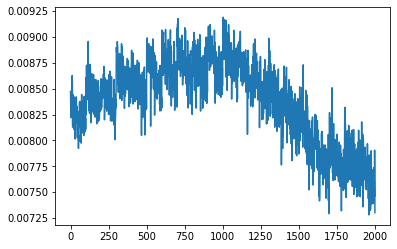

In [18]:
plt.plot(dl)

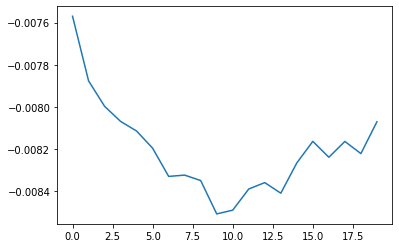

In [19]:
plt.plot(gl)

In [0]:
generated = generator_model.predict(noise(20)).reshape(20, 28,28)

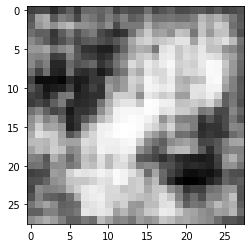

In [21]:
plt.imshow(generated[3], cmap='gray')

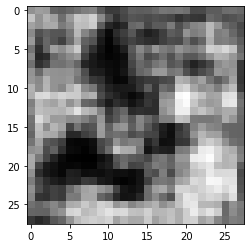

In [22]:
plt.imshow(generated[11], cmap='gray')

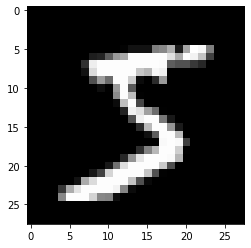

In [23]:
plt.imshow(X_train[0][:,:,0], cmap='gray')